# Bank of America Quantitative Wealth and Investment Management Capstone Project

## Section1: Comparison of Models

## 1. Import Liabraries

In [5]:
import cvxpy as cp
import datetime

import fastparquet
import empyrical
import numpy as np
import pandas as pd
# import mgarch

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.covariance import LedoitWolf

## 2. Data

In [2]:
# process FF 5 factor model data
ff5 = pd.read_csv('./Data/F-F_Research_Data_5_Factors_2x3_daily.CSV', header = 2)
ff5 = ff5.rename(columns = {'Unnamed: 0': 'Date'})
ff5['Date'] = pd.to_datetime(ff5['Date'].astype('str'))
ff5 = ff5.set_index('Date').loc['2000-01-01':'2023-04-28']
ff5 = ff5 / 100
rf = pd.DataFrame(ff5.pop('RF'))

ff5.to_parquet('./Data/ff5.pq')
rf.to_parquet('./Data/rf.pq')

In [3]:
ff5.tail()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2023-04-24,0.0000,-0.0027,0.0047,0.0066,0.0028
2023-04-25,-0.0176,-0.0083,0.0010,0.0044,0.0089
2023-04-26,-0.0041,-0.0004,-0.0075,0.0005,-0.0033
2023-04-27,0.0185,-0.0059,0.0000,0.0046,-0.0019
2023-04-28,0.0077,0.0021,0.0017,0.0011,0.0023


In [4]:
# merge all price data
filePath = r'./Raw_Dataset/'
df_list = []
for i in os.listdir(filePath):
    df = pd.read_excel(filePath + i)
    df.set_index('Date', inplace = True)
    df = df[['Last Price']]
    df.columns = [i[:-5]] # delete '.xlsx'
    df_list.append(df)

In [5]:
# asset daily price
price_df = pd.concat(df_list, axis = 1).dropna(how = 'all').sort_index().loc['2000-01-01':'2023-04-28'].fillna(method = 'ffill')
price_df = price_df.loc[ff5.index]
price_df.to_parquet('./Data/price.pq')

In [6]:
price_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-24,234.5550,2113.32,1380.710,1273.2159,8731.449,7067.986,12191.81,7332.327,7713.852,7434.153,...,663.35,551.26,1573.41,853.37,2576.08,511.57,232.52,191.14,355.54,8857.30
2023-04-25,231.5306,2127.79,1380.205,1275.0060,8661.843,7117.566,11991.62,7260.257,7656.400,7387.525,...,651.16,541.55,1556.86,837.71,2522.36,500.58,230.39,188.12,355.20,8717.63
2023-04-26,228.9936,2119.67,1380.257,1275.4860,8633.530,7083.893,11946.41,7257.238,7659.783,7367.328,...,642.83,536.37,1534.96,822.05,2566.05,494.68,228.49,186.95,346.78,8684.19
2023-04-27,228.7664,2110.45,1380.366,1273.0880,8626.219,7075.156,12171.78,7257.544,7648.076,7369.159,...,645.68,544.95,1542.80,838.37,2621.78,501.40,234.04,197.28,350.94,8854.32
2023-04-28,230.9578,2122.20,1385.417,1273.9310,8693.436,7048.695,12271.10,7275.364,7745.855,7412.138,...,655.20,551.42,1555.39,846.11,2649.95,507.06,236.74,198.35,350.26,8928.35


## 3. Historical Daily Return

In [7]:
# asset daily return
return_df = price_df.pct_change().iloc[1:]
return_df.to_parquet('./Data/return.pq')

In [8]:
return_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-24,0.004414,0.004105,0.001798,0.000580,0.006546,0.000492,0.000546,-0.001476,0.005085,0.003608,...,0.015383,-0.002010,0.005579,0.002267,-0.004240,0.006928,-0.003087,-0.000105,0.004975,0.000852
2023-04-25,-0.012894,0.006847,-0.000366,0.001406,-0.007972,0.007015,-0.016420,-0.009829,-0.007448,-0.006272,...,-0.018376,-0.017614,-0.010519,-0.018351,-0.020853,-0.021483,-0.009161,-0.015800,-0.000956,-0.015769
2023-04-26,-0.010958,-0.003816,0.000038,0.000376,-0.003269,-0.004731,-0.003770,-0.000416,0.000442,-0.002734,...,-0.012793,-0.009565,-0.014067,-0.018694,0.017321,-0.011786,-0.008247,-0.006219,-0.023705,-0.003836
2023-04-27,-0.000992,-0.004350,0.000079,-0.001880,-0.000847,-0.001233,0.018865,0.000042,-0.001528,0.000249,...,0.004434,0.015996,0.005108,0.019853,0.021718,0.013585,0.024290,0.055255,0.011996,0.019591
2023-04-28,0.009579,0.005568,0.003659,0.000662,0.007792,-0.003740,0.008160,0.002455,0.012785,0.005832,...,0.014744,0.011873,0.008160,0.009232,0.010745,0.011288,0.011536,0.005424,-0.001938,0.008361


In [13]:
# today and next 4 days return
return_next_week_df = np.log(1 + return_df).rolling(5).sum().shift(-4).dropna(how = 'all') 
return_next_week_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-18,-0.018051,0.006561,-0.001616,-0.010523,0.018133,0.004314,-0.004009,-0.012968,0.012606,0.008688,...,0.002339,-0.003477,0.004235,0.001912,-0.012825,-0.002089,-0.009374,-0.018351,0.010092,-0.003321
2023-04-19,-0.037797,0.012237,-0.002931,-0.000531,0.002245,0.000107,-0.021664,-0.023856,-0.003731,-0.005036,...,-0.020656,-0.024371,0.000231,-0.021236,-0.037960,-0.027778,-0.017042,-0.027784,0.014262,-0.020069
2023-04-20,-0.035795,0.009509,-0.000264,0.002711,0.000629,0.000108,-0.025093,-0.021847,-0.003367,-0.005456,...,-0.031015,-0.036537,-0.016771,-0.039406,-0.019481,-0.036501,-0.030813,-0.026758,-0.017522,-0.023828
2023-04-21,-0.028122,0.001138,0.001505,0.000570,-0.000686,-0.004383,-0.000520,-0.024467,-0.006585,-0.006133,...,-0.017669,-0.017481,-0.007330,-0.017898,0.009612,-0.022267,0.005141,0.034709,-0.005059,0.001435
2023-04-24,-0.011051,0.008290,0.005200,0.001141,0.002162,-0.002241,0.007028,-0.009276,0.009212,0.000636,...,0.002904,-0.001721,-0.005955,-0.006280,0.024023,-0.001951,0.014895,0.036922,-0.010000,0.008841


In [107]:
# performance metrics
performance_dict = {}
for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio']:
    fuc = eval('empyrical.' + metric)
    performance_dict[metric] = {}
    for asset in return_df.columns:
        performance_dict[metric].update({asset: fuc(return_df[asset])})

In [108]:
pd.DataFrame(performance_dict).sort_values('sharpe_ratio', ascending=False)

,annual_return,sharpe_ratio,max_drawdown,calmar_ratio
LMBITR,0.043375,1.382286,-0.134196,0.323222
LG30TRUU,0.066934,1.251274,-0.351638,0.190349
LBUSTRUU,0.041180,1.017861,-0.184050,0.223741
RUMCINTR,0.087029,0.499012,-0.589279,0.147687
S5CONS,0.060807,0.462823,-0.348358,0.174554
RU20VATR,0.086124,0.461740,-0.617141,0.139553
S5HLTH,0.069544,0.459131,-0.431795,0.161058
RU10VATR,0.070287,0.440524,-0.601140,0.116923
SPXT,0.066321,0.423482,-0.552502,0.120038
NDDUPXJ (Start from 1999),0.063310,0.406974,-0.641258,0.098727


In [17]:
df_ret = return_df.copy()

In [18]:
all_df = pd.concat([return_df, ff5, rf], axis = 1).loc[return_df.index]
code_list = return_df.columns
ff5_list = ff5.columns
rf_list = rf.columns
all_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5RLST,S5TELS,S5UTIL,SPXT,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-24,0.004414,0.004105,0.001798,0.000580,0.006546,0.000492,0.000546,-0.001476,0.005085,0.003608,...,-0.003087,-0.000105,0.004975,0.000852,0.0000,-0.0027,0.0047,0.0066,0.0028,0.00018
2023-04-25,-0.012894,0.006847,-0.000366,0.001406,-0.007972,0.007015,-0.016420,-0.009829,-0.007448,-0.006272,...,-0.009161,-0.015800,-0.000956,-0.015769,-0.0176,-0.0083,0.0010,0.0044,0.0089,0.00018
2023-04-26,-0.010958,-0.003816,0.000038,0.000376,-0.003269,-0.004731,-0.003770,-0.000416,0.000442,-0.002734,...,-0.008247,-0.006219,-0.023705,-0.003836,-0.0041,-0.0004,-0.0075,0.0005,-0.0033,0.00018
2023-04-27,-0.000992,-0.004350,0.000079,-0.001880,-0.000847,-0.001233,0.018865,0.000042,-0.001528,0.000249,...,0.024290,0.055255,0.011996,0.019591,0.0185,-0.0059,0.0000,0.0046,-0.0019,0.00018
2023-04-28,0.009579,0.005568,0.003659,0.000662,0.007792,-0.003740,0.008160,0.002455,0.012785,0.005832,...,0.011536,0.005424,-0.001938,0.008361,0.0077,0.0021,0.0017,0.0011,0.0023,0.00018


## 4. Expected Return 
### Bayes-Stein Estimator

In [19]:
# Bayes-Stein estimator
def bayes_stein_estimator(returns_df):
    Y = returns_df.mean()
    S = returns_df.cov()
    inv_S = np.linalg.inv(S.values)
    N = len(Y)
    T = len(returns_df)
    one_vector = np.ones(N)
    y0 = (one_vector @ inv_S @ Y.values) / (one_vector @ inv_S @ one_vector)
    _lambda = (N + 2) * (T - 1) / ((Y.values - y0 * one_vector).T @ inv_S @ (Y.values - y0 * one_vector) * (T - N - 2))
    w = _lambda / (_lambda + T)
    return (1 - w) * Y + w * y0 * one_vector

In [20]:
# Rolling window length 6 months approx 21 trading days in a month
window = 20 * 21

# Store the Bayes-Stein estimates
bayes_stein_forecasts = []
index_list = []

# Iterate through the time index
for end in range(window, len(return_df)):
    # Data for the current window
    window_data = return_df.iloc[end-window:end].dropna(axis = 1)
    index_list.append(return_df.index[end])
    
    # Bayes-Stein estimator for the current window
    forecast = bayes_stein_estimator(window_data)
    bayes_stein_forecasts.append(forecast)
    
bayes_stein_forecasts_df = pd.DataFrame(bayes_stein_forecasts, index=index_list).loc[:, df_ret.columns]
bayes_stein_forecasts_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
2023-04-24,0.000144,-0.000227,-0.000215,-0.000167,-0.000083,-0.000170,-0.000126,-0.000116,0.000063,-0.000095,...,0.000741,-0.000179,-0.000075,-0.000073,-0.000062,-0.000077,-0.000299,-0.000426,-0.000044,-0.000094
2023-04-25,0.000161,-0.000221,-0.000212,-0.000165,-0.000078,-0.000158,-0.000133,-0.000111,0.000070,-0.000089,...,0.000762,-0.000188,-0.000073,-0.000071,-0.000080,-0.000075,-0.000307,-0.000437,-0.000050,-0.000101
2023-04-26,0.000124,-0.000214,-0.000216,-0.000164,-0.000101,-0.000172,-0.000163,-0.000136,0.000051,-0.000112,...,0.000704,-0.000217,-0.000084,-0.000101,-0.000119,-0.000109,-0.000315,-0.000473,-0.000035,-0.000129
2023-04-27,0.000095,-0.000218,-0.000220,-0.000165,-0.000107,-0.000190,-0.000172,-0.000149,0.000046,-0.000123,...,0.000670,-0.000238,-0.000098,-0.000131,-0.000099,-0.000131,-0.000317,-0.000486,-0.000057,-0.000137
2023-04-28,0.000081,-0.000225,-0.000225,-0.000171,-0.000111,-0.000192,-0.000157,-0.000155,0.000034,-0.000126,...,0.000651,-0.000237,-0.000095,-0.000120,-0.000079,-0.000126,-0.000290,-0.000426,-0.000051,-0.000122


In [21]:
# next day IC
IC = bayes_stein_forecasts_df.fillna(0).corrwith(return_df, axis = 1).dropna()
IR = IC.mean() / IC.std() * np.sqrt(250)
print('IC_mean:', IC.mean())
print('IR:', IR)

IC_mean: 0.01650771119022395
IR: 0.7275280161980151


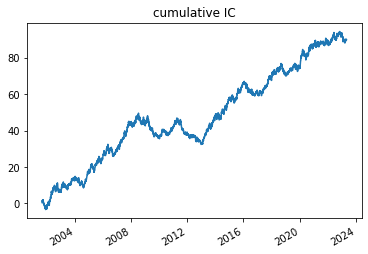

In [22]:
IC.cumsum().plot()
plt.title('cumulative IC')
plt.show()

In [23]:
# next week IC
IC = bayes_stein_forecasts_df.fillna(0).corrwith(return_next_week_df, axis = 1).dropna()
IR = IC.mean() / IC.std() * np.sqrt(50)
print('IC_mean:', IC.mean())
print('IR:', IR)

IC_mean: 0.03621182409768822
IR: 0.6607912924585847


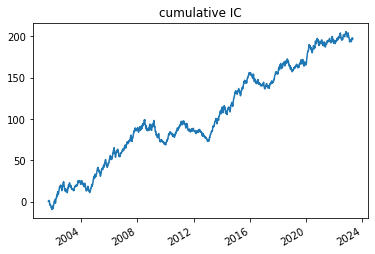

In [24]:
IC.cumsum().plot()
plt.title('cumulative IC')
plt.show()

Bayes-Stein Estimator is not a good enough predictor

### Linear Regression

In [25]:
log_return_df = np.log(1 + return_df)

In [26]:
# next day IC
window_list = [i * 20 + 1 for i in range(30)]
dict_ic_ir = {}
for window in window_list:
    X = log_return_df.rolling(window).mean().shift(1).dropna(how = 'all').fillna(0)
    IC = X.corrwith(return_df, axis = 1).dropna()
    IC_mean = IC.mean()
    IR = IC_mean / IC.std() * np.sqrt(250)
    dict_ic_ir[window] = {'IC_mean': IC_mean, 'IR':IR}
pd.DataFrame(dict_ic_ir).T

,IC_mean,IR
1,-0.069114,-2.919221
21,-0.023867,-1.030684
41,-0.015611,-0.677337
61,-0.008008,-0.346883
81,-0.001282,-0.055712
101,-0.002872,-0.125137
121,0.002978,0.128632
141,0.005106,0.219563
161,0.008301,0.355827
181,0.008969,0.385250


In [27]:
# next day IC
window_list = [i + 1 for i in range(30)]
dict_ic_ir = {}
for window in window_list:
    X = log_return_df.rolling(window).mean().shift(1).dropna(how = 'all').fillna(0)
    IC = X.corrwith(return_df, axis = 1).dropna()
    IC_mean = IC.mean()
    IR = IC_mean / IC.std() * np.sqrt(250)
    dict_ic_ir[window] = {'IC_mean': IC_mean, 'IR':IR}
pd.DataFrame(dict_ic_ir).T

,IC_mean,IR
1,-0.069114,-2.919221
2,-0.067340,-2.852219
3,-0.061332,-2.631378
4,-0.056009,-2.451920
5,-0.054033,-2.339288
6,-0.051371,-2.243844
7,-0.046248,-2.020163
8,-0.043323,-1.883571
9,-0.041276,-1.801011
10,-0.039714,-1.733650


In [28]:
# next week IC
window_list = [i * 20 + 1 for i in range(60)]
dict_ic_ir = {}
for window in window_list:
    X = log_return_df.rolling(window).mean().shift(1).dropna(how = 'all').fillna(0)
    IC = X.corrwith(return_next_week_df, axis = 1).dropna()
    IC_mean = IC.mean()
    IR = IC_mean / IC.std() * np.sqrt(250)
    dict_ic_ir[window] = {'IC_mean': IC_mean, 'IR':IR}
pd.DataFrame(dict_ic_ir).T

,IC_mean,IR
1,-0.052420,-2.296043
21,-0.021264,-0.901675
41,-0.015363,-0.644967
61,-0.004601,-0.189995
81,0.007971,0.328938
101,0.004207,0.172512
121,0.013051,0.526083
141,0.013102,0.528767
161,0.021096,0.843186
181,0.022410,0.888501


In [29]:
# next week IC
window_list = [i + 1 for i in range(30)]
dict_ic_ir = {}
for window in window_list:
    X = log_return_df.rolling(window).mean().shift(1).dropna(how = 'all').fillna(0)
    IC = X.corrwith(return_next_week_df, axis = 1).dropna()
    IC_mean = IC.mean()
    IR = IC_mean / IC.std() * np.sqrt(250)
    dict_ic_ir[window] = {'IC_mean': IC_mean, 'IR':IR}
pd.DataFrame(dict_ic_ir).T

,IC_mean,IR
1,-0.052420,-2.296043
2,-0.054007,-2.346328
3,-0.051319,-2.231193
4,-0.049121,-2.156650
5,-0.047839,-2.104084
6,-0.043956,-1.923382
7,-0.040069,-1.749441
8,-0.036144,-1.583822
9,-0.031726,-1.398709
10,-0.029804,-1.308960


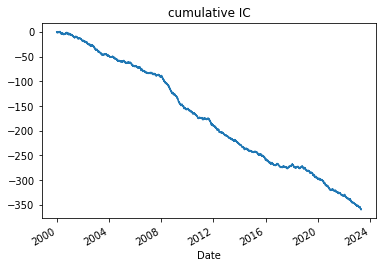

In [30]:
window = 3
X_1 = log_return_df.rolling(window).mean().shift(1).dropna(how = 'all').fillna(0)
IC = X_1.corrwith(return_df, axis = 1).dropna()
IC.cumsum().plot()
plt.title('cumulative IC')
plt.show()

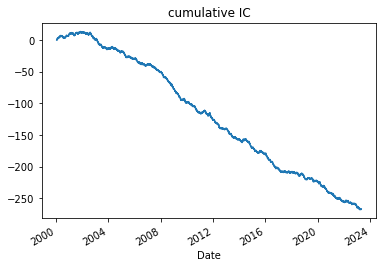

In [31]:
window = 10
min_df = log_return_df.rolling(window).min()
max_df = log_return_df.rolling(window).max()
X_2 = ((log_return_df - min_df) / (max_df - min_df)).shift(1).dropna(how = 'all').fillna(0)
IC = X_2.corrwith(return_df, axis = 1).dropna()
IC.cumsum().plot()
plt.title('cumulative IC')
plt.show()

### short term reversal effect and long term momentum effect

In [32]:
# we use some factors to predict the next-day return
reg_df = pd.DataFrame()
reg_df['X_0'] = bayes_stein_forecasts_df.apply(lambda x: (x - x.mean()) / x.std(), axis = 1).T.unstack() # standardize
reg_df['X_1'] = X_1.apply(lambda x: (x - x.mean()) / x.std(), axis = 1).T.unstack() 
reg_df['X_2'] = X_2.apply(lambda x: (x - x.mean()) / x.std(), axis = 1).T.unstack()
reg_df['y'] = return_df.T.unstack()
reg_df.dropna(inplace = True)
reg_df.tail()

X_0       X_1       X_2         y
2023-04-28 S5MATR  0.129504 -0.937283  0.663251  0.011288
           S5RLST -0.730866  1.031432  0.663251  0.011536
           S5TELS -1.442191  2.889561  0.663251  0.005424
           S5UTIL  0.517907 -0.414849  0.663251 -0.001938
           SPXT    0.149780  0.524205  0.663251  0.008361

In [33]:
reg_df.corr()

,X_0,X_1,X_2,y
X_0,1.000000,0.107953,0.011165,-0.003673
X_1,0.107953,1.000000,0.306675,-0.049413
X_2,0.011165,0.306675,1.000000,-0.040196
y,-0.003673,-0.049413,-0.040196,1.000000


In [34]:
# Iterate through the time index
window = 500
start = 500
reg_forecasts_dict = {}

for end in range(start, len(return_df)):
    # regression
    train_start_date = return_df.index[end-window]
    train_end_date = return_df.index[end-1]
    
    train_window_df = reg_df.loc[train_start_date:train_end_date]
    test_window_df = reg_df.loc[return_df.index[end]]
    
    test_window_df.pop('y')
    test_X = test_window_df
     
    y = train_window_df.pop('y')
    X = train_window_df
    
    model = LinearRegression()
    reg = model.fit(X, y)
    y_pred = reg.predict(test_X)

    # Bayes-Stein estimator for the current window
    reg_forecasts_dict[return_df.index[end]] = dict(zip(test_X.index, y_pred))
reg_forecasts_df = pd.DataFrame(reg_forecasts_dict).T
reg_forecasts_df.tail()

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5TELS,S5UTIL,SPXT,RUMRINTR,S5RLST
2023-04-24,0.002074,-0.000647,-0.000119,-0.000660,-0.000980,0.000423,0.000080,0.000955,-0.000154,-0.000177,...,0.000307,-0.001187,0.000327,0.000754,0.000989,0.000522,-0.001624,0.000009,-0.000393,-0.000104
2023-04-25,0.000510,-0.001310,-0.000455,-0.000724,-0.001539,0.000071,0.000344,0.000844,-0.000741,-0.000599,...,0.000946,-0.001138,-0.000026,0.001449,-0.000306,0.000334,-0.001264,0.000267,0.000753,0.001118
2023-04-26,0.000290,-0.001884,-0.000968,-0.001488,-0.000811,-0.001266,0.000272,0.000627,-0.000284,-0.000376,...,0.000730,-0.000672,0.000446,0.001014,0.000732,0.000149,-0.001397,0.000199,0.000965,-0.000144
2023-04-27,0.000296,-0.001051,-0.001099,-0.001538,-0.000625,-0.000813,0.000026,-0.000600,-0.000955,-0.000538,...,0.000656,0.000374,0.001199,-0.001042,0.000484,0.000330,0.000414,-0.000008,0.000994,0.000257
2023-04-28,0.001016,0.000367,-0.000215,-0.000244,0.000498,0.000045,-0.000452,0.000117,0.000422,0.000346,...,0.000038,0.000496,0.000336,-0.001402,0.000451,-0.002069,0.000100,-0.000519,0.001372,-0.000844


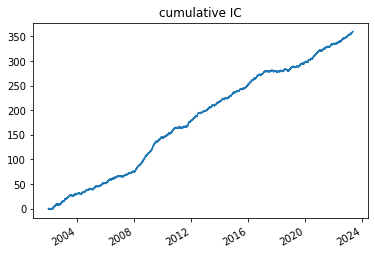

In [35]:
IC = reg_forecasts_df.corrwith(return_df, axis = 1).dropna()
IC.cumsum().plot()
plt.title('cumulative IC')
plt.show()

In [36]:
IR = IC.mean() / IC.std() * np.sqrt(250)
print('IC_mean:', IC.mean())
print('IR:', IR)

IC_mean: 0.06706282686807341
IR: 3.081449919169743


## 5. Covariance Matrix 
### 5.1 Fama-French 5 Model

In [37]:
start_date = '2000-01-04'
end_date = '2023-04-28'

In [38]:
# calculate factor exposure and residual volatility

def calc_cov_FF5(all_df, start_date, end_date, if_output_beta = False):
    '''calc cov matrix using data from start_date to end_date(inclusive)'''
    window_df = all_df.loc[start_date:end_date]
    return_window = window_df.loc[:,code_list]
    return_window = return_window.loc[:,return_window.count() > len(return_window)//2] # drop columns with too many nan
    ff5_window = window_df.loc[:,ff5_list]
    rf_window = window_df.loc[:,rf_list]

    beta_list = []
    resid_var_list = []
    window_code_list = return_window.columns
    for i in window_code_list:
        y = return_window[[i]].values - rf_window.values
        X = ff5_window.values

        nan_index = ~np.isnan(y)
        y = y[nan_index]
        X = X[nan_index.reshape(-1)]
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)

        resid = y - y_pred
        resid_var_list.append(resid.var())
        beta_list.append(reg.coef_)

    # calculate cov matrix
    beta_matrix = np.array(beta_list)
    ff5_cov_matrix = ff5_window.cov().values
    D = np.diag(np.array(resid_var_list)) # cov matrix of residual vol
    cov_matrix = beta_matrix @ ff5_cov_matrix @ beta_matrix.T + D
    cov_df = pd.DataFrame(cov_matrix, index = window_code_list, columns = window_code_list)
    
    if if_output_beta:
        return(cov_df, pd.DataFrame(beta_matrix,index = window_code_list, columns = ff5_list))
    
    return(cov_df)

cov_df, beta_df = calc_cov_FF5(all_df, start_date, end_date, if_output_beta = True)

In [39]:
# factor exposure
beta_df

,Mkt-RF,SMB,HML,RMW,CMA
BCOMTR,0.209369,0.077021,0.150727,0.022892,0.005097
LBUSTRUU,-0.036054,0.004616,-0.043158,0.030201,-0.020987
LG30TRUU,0.088729,0.018616,0.028210,-0.002888,-0.016926
LMBITR,-0.001880,-0.002725,-0.029759,0.023945,0.013755
NDDUE15X,0.611153,-0.025310,0.167979,-0.133218,0.078472
NDDUJN,0.052635,-0.029616,-0.003631,-0.122497,-0.017493
NDDUNA (Start from 1998),0.996956,-0.115482,0.024523,0.076389,0.025229
NDDUPXJ (Start from 1999),0.258901,0.016104,0.118255,-0.093699,-0.041445
NDDUUK,0.573989,-0.055663,0.240793,-0.038632,0.091079
NDDUWXUS,0.460399,-0.034716,0.149434,-0.043702,0.061052


In [40]:
cov_df

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
BCOMTR,1.061190e-04,-1.797774e-06,3.487756e-06,-5.097753e-07,0.000023,2.087503e-06,0.000033,1.067438e-05,0.000022,1.736426e-05,...,0.000041,0.000052,2.315678e-05,0.000037,0.000036,0.000038,0.000043,2.776167e-05,2.208016e-05,0.000034
LBUSTRUU,-1.797774e-06,6.487394e-06,-6.540917e-07,1.269868e-07,-0.000005,-4.468270e-07,-0.000006,-2.094556e-06,-0.000004,-3.385638e-06,...,-0.000008,-0.000011,-4.183479e-06,-0.000007,-0.000006,-0.000007,-0.000008,-5.137944e-06,-4.236580e-06,-0.000006
LG30TRUU,3.487756e-06,-6.540917e-07,1.112205e-05,-1.640963e-07,0.000010,1.034507e-06,0.000014,4.380710e-06,0.000009,7.082189e-06,...,0.000015,0.000020,9.970821e-06,0.000015,0.000017,0.000015,0.000017,1.234383e-05,8.964651e-06,0.000015
LMBITR,-5.097753e-07,1.269868e-07,-1.640963e-07,3.835112e-06,-0.000001,-1.268290e-07,-0.000001,-5.680438e-07,-0.000001,-8.097586e-07,...,-0.000002,-0.000003,-4.284830e-07,-0.000001,-0.000001,-0.000001,-0.000002,-7.868906e-07,-6.058576e-07,-0.000001
NDDUE15X,2.316506e-05,-4.519445e-06,9.572456e-06,-1.093237e-06,0.000195,7.200965e-06,0.000098,2.948277e-05,0.000060,4.812341e-05,...,0.000104,0.000136,6.897773e-05,0.000102,0.000117,0.000103,0.000114,8.497249e-05,6.270107e-05,0.000098
NDDUJN,2.087503e-06,-4.468270e-07,1.034507e-06,-1.268290e-07,0.000007,1.795923e-04,0.000011,3.344739e-06,0.000006,5.096594e-06,...,0.000009,0.000013,6.824122e-06,0.000010,0.000016,0.000010,0.000011,9.729071e-06,5.614402e-06,0.000011
NDDUNA (Start from 1998),3.339510e-05,-6.156687e-06,1.441564e-05,-1.175674e-06,0.000098,1.085600e-05,0.000154,4.369392e-05,0.000090,7.237936e-05,...,0.000154,0.000198,1.108152e-04,0.000156,0.000187,0.000159,0.000170,1.353012e-04,9.813990e-05,0.000154
NDDUPXJ (Start from 1999),1.067438e-05,-2.094556e-06,4.380710e-06,-5.680438e-07,0.000029,3.344739e-06,0.000044,1.597875e-04,0.000027,2.176779e-05,...,0.000047,0.000063,2.971476e-05,0.000045,0.000052,0.000046,0.000052,3.744435e-05,2.705064e-05,0.000044
NDDUUK,2.209359e-05,-4.355334e-06,8.848710e-06,-1.071748e-06,0.000060,6.152815e-06,0.000090,2.725198e-05,0.000186,4.494441e-05,...,0.000100,0.000130,6.417335e-05,0.000095,0.000103,0.000097,0.000107,7.786696e-05,5.974552e-05,0.000091
NDDUWXUS,1.736426e-05,-3.385638e-06,7.082189e-06,-8.097586e-07,0.000048,5.096594e-06,0.000072,2.176779e-05,0.000045,1.198435e-04,...,0.000078,0.000102,5.158119e-05,0.000076,0.000085,0.000077,0.000085,6.292903e-05,4.736813e-05,0.000073


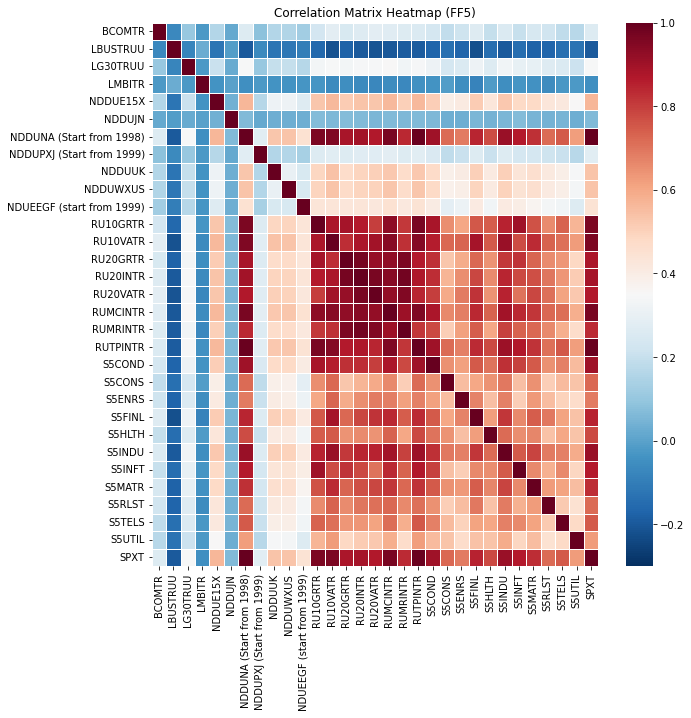

In [41]:
# from cov matrix to correlation matrix
diag_inv_std_matrix = np.sqrt(np.diag(np.diag(1 / cov_df)))
df1 = diag_inv_std_matrix @ cov_df @ diag_inv_std_matrix
df1 = pd.DataFrame(df1.values, index = cov_df.index, columns = cov_df.columns)

plt.figure(figsize=(10,10))
sns.heatmap(df1, 
            xticklabels=cov_df.columns, 
            yticklabels=cov_df.columns, 
            vmin = -0.3,
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix Heatmap (FF5)')
plt.show()

In [42]:
# Set a threshold
threshold = 0.7

# Get pairs with correlation above the threshold
highly_correlated_pairs = [(col1, col2, df1[col1][col2]) for col1 in df1.index for col2 in df1.columns if (col1 != col2) and (abs(df1[col1][col2]) > threshold)]

# Convert list of tuples into a DataFrame
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation']).sort_values('Correlation', ascending = False)

# some pairs are highly correlated
highly_correlated_df.iloc[:21,:]

,Variable 1,Variable 2,Correlation
238,SPXT,NDDUNA (Start from 1998),0.995233
17,NDDUNA (Start from 1998),SPXT,0.995233
246,SPXT,RUTPINTR,0.994015
144,RUTPINTR,SPXT,0.994015
127,RUTPINTR,NDDUNA (Start from 1998),0.992710
7,NDDUNA (Start from 1998),RUTPINTR,0.992710
73,RU20INTR,RUMRINTR,0.976469
117,RUMRINTR,RU20INTR,0.976469
70,RU20INTR,RU20GRTR,0.971597
56,RU20GRTR,RU20INTR,0.971597


### 5.2 Double-shrinkage Model

In [43]:
# calculate factor exposure and residual volatility

def calc_cov_ds(all_df, start_date, end_date, if_output_beta = False, alpha = 5 * 10 ** -5):
    '''calc cov matrix using data from start_date to end_date(inclusive)'''
    window_df = all_df.loc[start_date:end_date]
    return_window = window_df.loc[:,code_list]
    return_window = return_window.loc[:,return_window.count() > len(return_window)//2] # drop columns with too many nan
    ff5_window = window_df.loc[:,ff5_list]
    rf_window = window_df.loc[:,rf_list]

    beta_list = []
    resid_var_list = []
    window_code_list = return_window.columns
    for i in window_code_list:
        y = return_window[[i]].values - rf_window.values
        X = ff5_window.values

        nan_index = ~np.isnan(y)
        y = y[nan_index]
        X = X[nan_index.reshape(-1)]
        
        model = ElasticNet(alpha = alpha)
        reg = model.fit(X, y)
        y_pred = reg.predict(X)

        resid = y - y_pred
        resid_var_list.append(resid.var())
        beta_list.append(reg.coef_)

    # calculate cov matrix
    beta_matrix = np.array(beta_list)
    ff5_cov_matrix = ff5_window.cov().values
    D = np.diag(np.array(resid_var_list)) # cov matrix of residual vol
    cov_matrix = beta_matrix @ ff5_cov_matrix @ beta_matrix.T + D
    cov_df = pd.DataFrame(cov_matrix, index = window_code_list, columns = window_code_list)
    
    if if_output_beta:
        return(cov_df, pd.DataFrame(beta_matrix,index = window_code_list, columns = ff5_list))
    
    return(cov_df)

cov_df, beta_df = calc_cov_ds(all_df, start_date, end_date, if_output_beta = True)

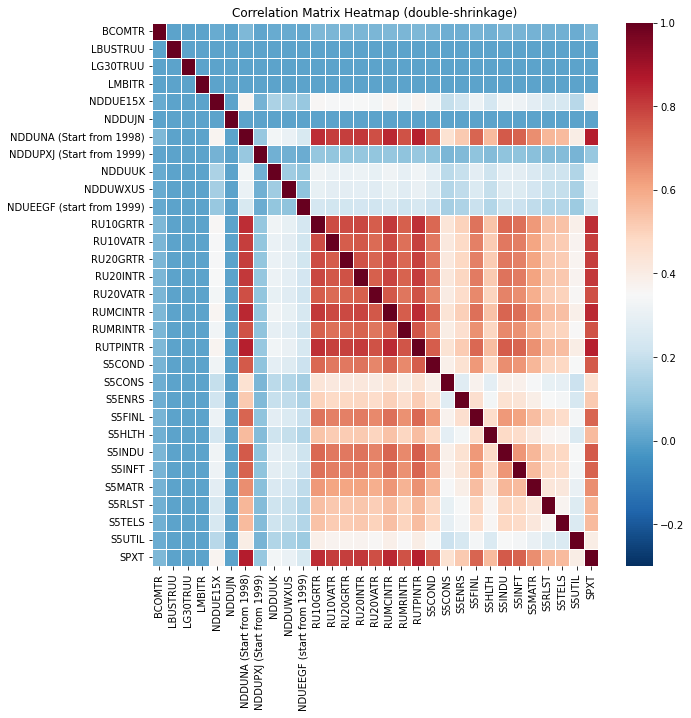

In [44]:
# from cov matrix to correlation matrix
diag_inv_std_matrix = np.sqrt(np.diag(np.diag(1 / cov_df)))
df1 = diag_inv_std_matrix @ cov_df @ diag_inv_std_matrix
df1 = pd.DataFrame(df1.values, index = cov_df.index, columns = cov_df.columns)

plt.figure(figsize=(10,10))
sns.heatmap(df1, 
            xticklabels=cov_df.columns, 
            yticklabels=cov_df.columns, 
            vmin = -0.3,
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix Heatmap (double-shrinkage)')
plt.show()

In [45]:
# Set a threshold
threshold = 0.7

# Get pairs with correlation above the threshold
highly_correlated_pairs = [(col1, col2, df1[col1][col2]) for col1 in df1.index for col2 in df1.columns if (col1 != col2) and (abs(df1[col1][col2]) > threshold)]

# Convert list of tuples into a DataFrame
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation']).sort_values('Correlation', ascending = False)

# some pairs are highly correlated
highly_correlated_df.iloc[:21,:]

,Variable 1,Variable 2,Correlation
121,SPXT,NDDUNA (Start from 1998),0.859265
12,NDDUNA (Start from 1998),SPXT,0.859265
129,SPXT,RUTPINTR,0.854215
98,RUTPINTR,SPXT,0.854215
86,RUTPINTR,NDDUNA (Start from 1998),0.853662
7,NDDUNA (Start from 1998),RUTPINTR,0.853662
127,SPXT,RUMCINTR,0.839099
76,RUMCINTR,SPXT,0.839099
64,RUMCINTR,NDDUNA (Start from 1998),0.838555
5,NDDUNA (Start from 1998),RUMCINTR,0.838555


### 5.3 Ledoit-Wolf shrinkage

http://www.ledoit.net/honey.pdf
The methodology of shrinking the covariance matrix involves combining the sample covariance matrix with a structured estimator, which can help stabilize the covariance matrix estimation. This approach reduces the condition number of the covariance matrix and improves the performance of various statistical methods that rely on the covariance matrix.

In [46]:
# Create a Ledoit-Wolf shrinkage covariance estimator
lw_covariance = LedoitWolf()

# Fit the estimator the data and get the covariance matrix
lw_cov = lw_covariance.fit(df_ret.dropna(how = 'all').fillna(0))

cov_lw = lw_cov.covariance_

In [47]:
def sample_cov(r, **kwargs):
    '''
    Returns the sample covariance of the supplied series of returns (a pd.DataFrame) 
    '''
    if not isinstance(r,pd.DataFrame):
        raise ValueError("Expected r to be a pd.DataFrame of returns series")
    return r.cov()

def cc_cov(r, **kwargs):
    '''
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    '''
    # correlation coefficents  
    rhos = r.corr()
    n = rhos.shape[0]
    # compute the mean correlation: since the matrix rhos is a symmetric with diagonals all 1, 
    # the mean correlation can be computed by:
    mean_rho = (rhos.values.sum() - n) / (n**2-n) 
    # create the constant correlation matrix containing 1 on the diagonal and the mean correlation outside
    ccor = np.full_like(rhos, mean_rho)
    np.fill_diagonal(ccor, 1.)
    # create the new covariance matrix by multiplying mean_rho*std_i*std_i 
    # the product of the stds is done via np.outer
    ccov = ccor * np.outer(r.std(), r.std())
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

def calc_cov_le(r, start_date, end_date, delta=0.2, **kwargs):
    '''
    Statistical shrinkage: it returns a covariance matrix estimator that shrinks between 
    the constant correlation and standard sample covariance estimators 
    '''
    r = r.loc[start_date:end_date, code_list]
    r = r.loc[:,r.count() > len(r)//2] # drop columns with too many nan
    
    samp_cov  = sample_cov(r, **kwargs)
    const_cov = cc_cov(r, **kwargs)
    return delta*const_cov + (1-delta)*samp_cov

In [48]:
start_date = '2000-01-04'
end_date = '2023-04-28'
shrunk_cov_matrix = calc_cov_le(df_ret, start_date, end_date)
shrunk_cov_matrix

,BCOMTR,LBUSTRUU,LG30TRUU,LMBITR,NDDUE15X,NDDUJN,NDDUNA (Start from 1998),NDDUPXJ (Start from 1999),NDDUUK,NDDUWXUS,...,S5ENRS,S5FINL,S5HLTH,S5INDU,S5INFT,S5MATR,S5RLST,S5TELS,S5UTIL,SPXT
BCOMTR,1.061387e-04,8.184035e-07,0.000011,1.628996e-06,5.626778e-05,0.000028,0.000041,0.000045,5.875857e-05,4.790734e-05,...,0.000092,4.901507e-05,2.546813e-05,0.000041,0.000043,0.000059,0.000046,3.168010e-05,0.000032,0.000039
LBUSTRUU,8.184035e-07,6.493921e-06,0.000002,2.432426e-06,8.964572e-08,0.000006,-0.000002,0.000003,-3.205835e-07,8.742378e-07,...,-0.000002,-3.720498e-06,-3.213651e-07,-0.000003,-0.000002,-0.000002,0.000002,4.658119e-07,0.000003,-0.000002
LG30TRUU,1.140793e-05,2.006512e-06,0.000011,1.945507e-06,2.577032e-05,0.000016,0.000016,0.000023,2.430039e-05,2.184869e-05,...,0.000021,1.988522e-05,1.169956e-05,0.000017,0.000018,0.000019,0.000017,1.445430e-05,0.000013,0.000015
LMBITR,1.628996e-06,2.432426e-06,0.000002,3.835946e-06,1.574456e-06,0.000003,0.000001,0.000003,1.882439e-06,1.632396e-06,...,0.000002,3.994086e-07,1.783884e-06,0.000001,0.000002,0.000001,0.000003,2.018835e-06,0.000004,0.000001
NDDUE15X,5.626778e-05,8.964572e-08,0.000026,1.574456e-06,1.952969e-04,0.000055,0.000097,0.000098,1.535389e-04,1.261658e-04,...,0.000117,1.287827e-04,7.020569e-05,0.000105,0.000112,0.000117,0.000105,8.746284e-05,0.000067,0.000095
NDDUJN,2.819132e-05,6.374836e-06,0.000016,3.487580e-06,5.497801e-05,0.000180,0.000026,0.000089,5.229272e-05,7.362973e-05,...,0.000038,2.884730e-05,1.696353e-05,0.000028,0.000034,0.000034,0.000020,2.720981e-05,0.000027,0.000024
NDDUNA (Start from 1998),4.101102e-05,-1.812303e-06,0.000016,1.359519e-06,9.710958e-05,0.000026,0.000154,0.000052,9.039541e-05,7.335429e-05,...,0.000147,1.811032e-04,1.030008e-04,0.000142,0.000171,0.000147,0.000159,1.258441e-04,0.000094,0.000138
NDDUPXJ (Start from 1999),4.529494e-05,2.839342e-06,0.000023,2.764920e-06,9.753242e-05,0.000089,0.000052,0.000160,9.683042e-05,9.310125e-05,...,0.000073,6.441896e-05,3.609281e-05,0.000056,0.000058,0.000068,0.000053,4.470277e-05,0.000041,0.000049
NDDUUK,5.875857e-05,-3.205835e-07,0.000024,1.882439e-06,1.535389e-04,0.000052,0.000090,0.000097,1.861193e-04,1.198370e-04,...,0.000122,1.217742e-04,6.651866e-05,0.000098,0.000099,0.000112,0.000098,8.043791e-05,0.000065,0.000088
NDDUWXUS,4.790734e-05,8.742378e-07,0.000022,1.632396e-06,1.261658e-04,0.000074,0.000073,0.000093,1.198370e-04,1.198060e-04,...,0.000095,9.500629e-05,5.280930e-05,0.000079,0.000082,0.000091,0.000078,6.502017e-05,0.000053,0.000071


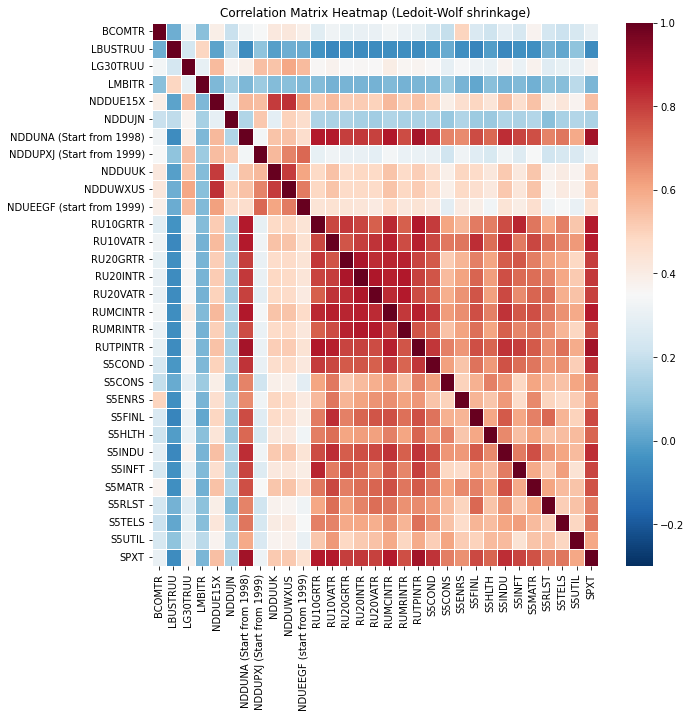

In [49]:
diag_inv_std_matrix = np.sqrt(np.diag(np.diag(1 / shrunk_cov_matrix)))
df1 = diag_inv_std_matrix @ shrunk_cov_matrix @ diag_inv_std_matrix
df1 = pd.DataFrame(df1.values, index = cov_df.index, columns = cov_df.columns)

plt.figure(figsize=(10,10))
sns.heatmap(df1, 
            xticklabels=cov_df.columns, 
            yticklabels=cov_df.columns, 
            vmin = -0.3,
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix Heatmap (Ledoit-Wolf shrinkage)')
plt.show()

In [50]:
# Set a threshold
threshold = 0.7

# Get pairs with correlation above the threshold
highly_correlated_pairs = [(col1, col2, df1[col1][col2]) for col1 in df1.index for col2 in df1.columns if (col1 != col2) and (abs(df1[col1][col2]) > threshold)]

# Convert list of tuples into a DataFrame
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation']).sort_values('Correlation', ascending = False)

# some pairs are highly correlated
highly_correlated_df.iloc[:21,:]

,Variable 1,Variable 2,Correlation
16,NDDUNA (Start from 1998),SPXT,0.894531
195,SPXT,NDDUNA (Start from 1998),0.894531
132,RUTPINTR,SPXT,0.894123
203,SPXT,RUTPINTR,0.894123
117,RUTPINTR,NDDUNA (Start from 1998),0.892382
9,NDDUNA (Start from 1998),RUTPINTR,0.892382
54,RU20GRTR,RU20INTR,0.881301
66,RU20INTR,RU20GRTR,0.881301
67,RU20INTR,RU20VATR,0.876944
81,RU20VATR,RU20INTR,0.876944


## 6. Portfolio Optimization

In [147]:
def evaluate(weight_df):
    '''evaluate the performance of given portfolio weight'''
    pf_return_df = (weight_df * return_df).dropna(how = 'all').sum(axis = 1)
    pf_price_df = (1 + pf_return_df).cumprod()
    
    performance_dict = {}
    for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio']:
        fuc = eval('empyrical.' + metric)
        performance_dict[metric] = fuc(pf_return_df)
        
    performance_dict['omega_ratio'] = empyrical.omega_ratio(pf_return_df, required_return = 0.05)
    performance_dict['sortino_ratio'] = empyrical.sortino_ratio(pf_return_df, required_return = 0.05 / 252)
        
    turnover_df = (weight_df - weight_df.shift(1)).dropna(how = 'all').abs().sum(axis = 1) / 2
    annual_turnover = turnover_df.mean() * 250
    performance_dict['annual_turnover'] = annual_turnover
    
    plt.plot(pf_price_df)
    plt.title('net value of portfolio')
    plt.show()
    
    plt.plot(np.log(pf_price_df))
    plt.title('log net value of portfolio')
    plt.show()
    
    return (pd.Series(performance_dict).round(5)), weight_df.mean().sort_values(ascending = False)

In [148]:
# def MVO_max_sharpe(mean, cov, weight_max = 0.2):
#     '''maximize expected_mean / np.sqrt(expected_var)'''
#     mean = mean.loc[cov.columns]
#     weight = cp.Variable(len(mean))
#     expected_return = weight.T @ mean
#     expected_var = cp.quad_form(weight, cov)

#     objective = cp.Minimize(expected_var)

    
#     len_mean = len(mean)
#     A =  - np.diag(np.ones(len_mean)) + weight_max * np.ones([len_mean, len_mean])
    
#     constraints = [
#         expected_return == 1,
#         weight >= 0, 
#         A @ weight >= 0 # weight_x <= weight_max
#     ]

#     problem = cp.Problem(objective, constraints)
#     problem.solve()

#     weight_x = weight / cp.sum(weight)

#     return weight_x.value

In [180]:
def MVO_max_utility(mean, cov, risk_aversion, weight_max = 0.2):
    '''maximize: expected_return - risk_aversion * expected_var'''
    
    mean = mean.loc[cov.columns]
    weight = cp.Variable(len(mean))
    expected_return = weight.T @ mean
    expected_var = cp.quad_form(weight, cov)

    utility = expected_return - risk_aversion * expected_var
    objective = cp.Maximize(utility)
    
    len_mean = len(mean)

    constraints = [
        cp.sum(weight) == 1,
        weight >= 0, 
        - np.diag(np.ones(len_mean)) @ weight >= - weight_max
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return weight.value

In [181]:
%%time
# max_return portfolio
window = 250
start = 750
date_index = return_df.index

# max return
weight_max_return_dict = {}

# ff5
weight_max_utility_dict = {}

# double shrinkage
weight_max_utility_ds_dict = {}

# ledoit-wolf
weight_max_utility_le_dict = {}


for end in range(start, len(date_index)):
    if end % 100 == 0:
        print(end)
    mean = reg_forecasts_df.loc[date_index[end]]

    start_date = date_index[end-window]
    end_date = date_index[end-1]
    cov = calc_cov_FF5(all_df, start_date, end_date)
    cov_ds = calc_cov_ds(all_df, start_date, end_date)
    cov_le = calc_cov_le(all_df, start_date, end_date)
    
    # max_return
    try:
        weight_max_return = MVO_max_utility(mean, cov, 0)
        weight_max_return_dict[date_index[end]] = dict(zip(cov.columns, weight_max_return))
    except:
        weight_max_return_dict[date_index[end]] = weight_max_return_dict[date_index[end - 1]]
        print('max_return error:', end)
    
    # ff5
    try:
        weight_max_utility = MVO_max_utility(mean, cov, 2)
        weight_max_utility_dict[date_index[end]] = dict(zip(cov.columns, weight_max_utility))
    except:
        weight_max_utility_dict[date_index[end]] = weight_max_utility_dict[date_index[end - 1]]
        print('max utility error:', end)
        
    # double shrinkage  
    try:
        weight_max_utility_ds = MVO_max_utility(mean, cov_ds, 2)
        weight_max_utility_ds_dict[date_index[end]] = dict(zip(cov_ds.columns, weight_max_utility_ds))
    except:
        weight_max_utility_ds_dict[date_index[end]] = weight_max_utility_ds_dict[date_index[end - 1]]
        print('max utility ds error:', end)

    # Ledoit-wolf   
    try:
        weight_max_utility_le = MVO_max_utility(mean, cov_le, 2)
        weight_max_utility_le_dict[date_index[end]] = dict(zip(cov_le.columns, weight_max_utility_le))
    except:
        weight_max_utility_le_dict[date_index[end]] = weight_max_utility_le_dict[date_index[end - 1]]
        print('max utility ledoit-wolf error:', end)

    
# Convert to dataframes
weight_max_return_df = pd.DataFrame(weight_max_return_dict).T

weight_max_utility_df = pd.DataFrame(weight_max_utility_dict).T

weight_max_utility_ds_df = pd.DataFrame(weight_max_utility_ds_dict).T

weight_max_utility_le_df = pd.DataFrame(weight_max_utility_le_dict).T  

800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
Wall time: 16min 25s


## 7. Performance Measure
### 7.1 Max return

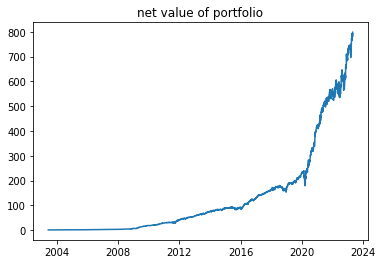

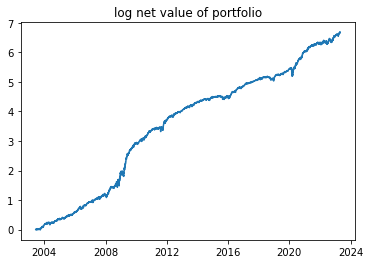

annual_return        0.39994
sharpe_ratio         1.92116
max_drawdown        -0.25134
calmar_ratio         1.59127
omega_ratio          1.39537
sortino_ratio        2.59701
annual_turnover    159.61079
dtype: float64

In [182]:
performance_r1, weight_mean_r1 = evaluate(weight_max_return_df)
performance_r1

In [183]:
weight_mean_r1.round(4)

NDDUJN                       0.0553
LBUSTRUU                     0.0535
LMBITR                       0.0528
BCOMTR                       0.0506
S5ENRS                       0.0490
S5RLST                       0.0454
NDUEEGF (start from 1999)    0.0450
S5UTIL                       0.0443
NDDUPXJ (Start from 1999)    0.0438
S5TELS                       0.0413
NDDUE15X                     0.0392
NDDUUK                       0.0387
S5FINL                       0.0386
S5INFT                       0.0354
S5MATR                       0.0347
RUMRINTR                     0.0347
S5HLTH                       0.0342
S5CONS                       0.0313
RU20GRTR                     0.0310
NDDUWXUS                     0.0288
RU20VATR                     0.0281
S5COND                       0.0276
LG30TRUU                     0.0269
RU20INTR                     0.0260
S5INDU                       0.0248
RU10GRTR                     0.0138
RUTPINTR                     0.0080
RU10VATR                    

## FF5 Covariance Performance

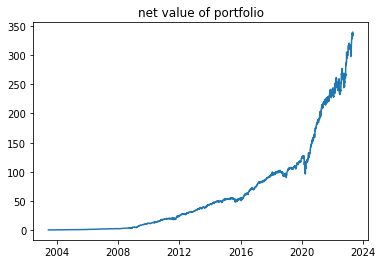

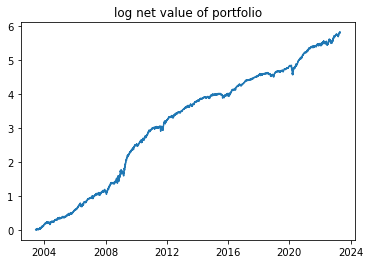

annual_return        0.34088
sharpe_ratio         1.95163
max_drawdown        -0.24300
calmar_ratio         1.40276
omega_ratio          1.37627
sortino_ratio        2.49935
annual_turnover    154.96638
dtype: float64

In [184]:
performance_u1, weight_mean_u1 = evaluate(weight_max_utility_df)
performance_u1

In [185]:
weight_mean_u1.round(4)

LBUSTRUU                     0.0675
LMBITR                       0.0668
NDDUJN                       0.0649
BCOMTR                       0.0590
NDDUPXJ (Start from 1999)    0.0497
NDUEEGF (start from 1999)    0.0497
S5UTIL                       0.0462
NDDUE15X                     0.0412
S5RLST                       0.0409
LG30TRUU                     0.0405
S5TELS                       0.0401
S5ENRS                       0.0398
NDDUUK                       0.0395
S5CONS                       0.0363
S5HLTH                       0.0352
NDDUWXUS                     0.0337
S5INFT                       0.0298
S5FINL                       0.0296
S5MATR                       0.0283
RUMRINTR                     0.0279
S5COND                       0.0243
S5INDU                       0.0220
RU20GRTR                     0.0213
RU20VATR                     0.0190
RU20INTR                     0.0143
RU10GRTR                     0.0108
RU10VATR                     0.0064
RUMCINTR                    

### 7.2 Double Shrinkage Covariance Performance

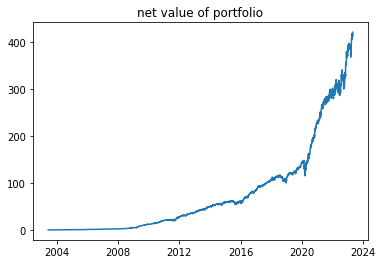

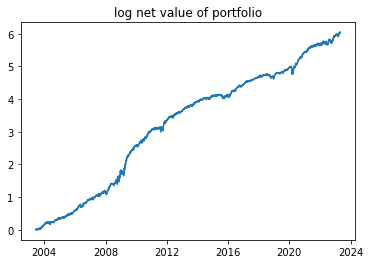

annual_return        0.35569
sharpe_ratio         1.93928
max_drawdown        -0.21904
calmar_ratio         1.62388
omega_ratio          1.37615
sortino_ratio        2.50573
annual_turnover    157.72169
dtype: float64

In [186]:
performance_u2, weight_mean_u2 = evaluate(weight_max_utility_ds_df)
performance_u2

In [187]:
weight_mean_u2.round(4)

LBUSTRUU                     0.0608
LMBITR                       0.0600
NDDUJN                       0.0594
BCOMTR                       0.0555
NDUEEGF (start from 1999)    0.0473
NDDUPXJ (Start from 1999)    0.0460
S5UTIL                       0.0450
S5ENRS                       0.0430
S5RLST                       0.0411
S5TELS                       0.0401
NDDUE15X                     0.0401
NDDUUK                       0.0388
S5HLTH                       0.0356
S5CONS                       0.0346
LG30TRUU                     0.0339
S5FINL                       0.0326
S5INFT                       0.0322
RUMRINTR                     0.0319
NDDUWXUS                     0.0318
S5MATR                       0.0314
RU20GRTR                     0.0266
S5COND                       0.0259
RU20VATR                     0.0238
S5INDU                       0.0238
RU20INTR                     0.0208
RU10GRTR                     0.0122
RU10VATR                     0.0076
RUTPINTR                    

### 7.3 Ledoit-Wolf Shrinkage Covariance Performance

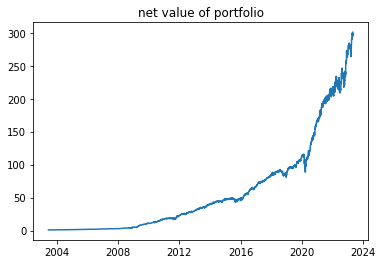

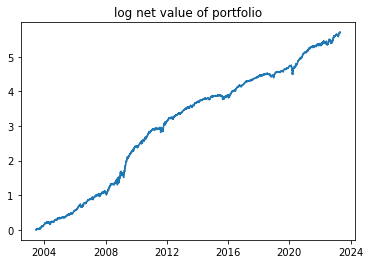

annual_return        0.33283
sharpe_ratio         1.90083
max_drawdown        -0.23341
calmar_ratio         1.42597
omega_ratio          1.36457
sortino_ratio        2.42286
annual_turnover    155.26933
dtype: float64

In [188]:
performance_u3, weight_mean_u3 = evaluate(weight_max_utility_le_df)
performance_u3

In [189]:
weight_mean_u3.round(4)

LMBITR                       0.0686
LBUSTRUU                     0.0684
NDDUJN                       0.0613
BCOMTR                       0.0579
S5UTIL                       0.0465
NDUEEGF (start from 1999)    0.0464
NDDUPXJ (Start from 1999)    0.0455
LG30TRUU                     0.0425
S5RLST                       0.0411
S5TELS                       0.0410
S5ENRS                       0.0403
NDDUE15X                     0.0377
S5CONS                       0.0373
S5HLTH                       0.0364
NDDUUK                       0.0359
S5FINL                       0.0315
S5INFT                       0.0311
S5MATR                       0.0295
RUMRINTR                     0.0292
NDDUWXUS                     0.0287
S5COND                       0.0255
S5INDU                       0.0234
RU20GRTR                     0.0227
RU20VATR                     0.0205
RU20INTR                     0.0157
RU10GRTR                     0.0115
RU10VATR                     0.0072
RUMCINTR                    

## 7.4 benchmark

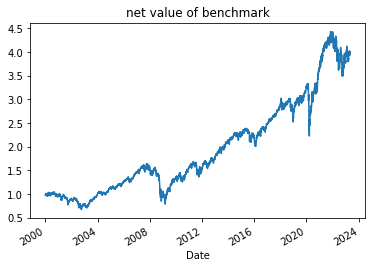

In [190]:
benchmark = (1 + (return_df).mean(axis = 1)).cumprod()
benchmark.plot()
plt.title('net value of benchmark')
plt.show()

In [191]:
performance_bm = {}
for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio']:
    fuc = eval('empyrical.' + metric)
    performance_bm[metric] = fuc((return_df).mean(axis = 1))
        
performance_bm['omega_ratio'] = empyrical.omega_ratio((return_df).mean(axis = 1), required_return = 0.05)
performance_bm['sortino_ratio'] = empyrical.sortino_ratio((return_df).mean(axis = 1), required_return = 0.05 / 252)
performance_bm['annual_turnover'] = 0

## summary

In [192]:
performance_dict = {'benchmark': performance_bm,
                    'max_return': performance_r1,
                    'MVO':performance_u1,
                    'MVO_ds':performance_u2,
                    'MVO_le':performance_u3}


In [194]:
pd.DataFrame(performance_dict).T.round(4)

,annual_return,sharpe_ratio,max_drawdown,calmar_ratio,omega_ratio,sortino_ratio,annual_turnover
benchmark,0.0614,0.4603,-0.5191,0.1184,1.0284,0.1920,0.0000
max_return,0.3999,1.9212,-0.2513,1.5913,1.3954,2.5970,159.6108
MVO,0.3409,1.9516,-0.2430,1.4028,1.3763,2.4994,154.9664
MVO_ds,0.3557,1.9393,-0.2190,1.6239,1.3762,2.5057,157.7217
MVO_le,0.3328,1.9008,-0.2334,1.4260,1.3646,2.4229,155.2693


In [2]:
!pip install empyrical -q

In [3]:
import time
import datetime
from datetime import timedelta
import empyrical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Section2: Reinforcement Learning With Gradient Ascent

## Reinforcement Learning with Gradient Ascent for Sharpe Ratio Maximization

In [4]:
np.random.seed(2)

class PortfolioOptimization:

    @staticmethod
    def optimize_portfolio_gradient_ascent(data, weights_init, alpha=0.02):
        def calculate_sharpe_ratio(mean_return, cov, weights):
            r = np.sum(mean_return * weights) * 252
            std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
            sha = r / std
            return r, std, sha

        returns = data.pct_change().iloc[1:, :]
        mean_returns = returns.mean()
        cov = returns.cov()
        n_stocks = len(data.columns)
        weights = weights_init
        ret, std_dev, sharpe = calculate_sharpe_ratio(mean_returns, cov, weights)
        a = alpha
        current_sharpe, current_weights = sharpe, weights
        results = [[ret, std_dev, sharpe] + list(current_weights)]
        
        for epochs in range(2000):
            current_results = []
            for i in range(n_stocks):
                w = current_weights.copy()
                w[i] += a
                w /= np.sum(w)
                ret_i, std_dev_i, sharpe_i = calculate_sharpe_ratio(mean_returns, cov, w)
                current_results.append([ret_i, std_dev_i, sharpe_i])
            current_result_sharpe_alpha = np.array(current_results)[:, 2] - current_sharpe
            current_max_alpha = current_result_sharpe_alpha.max()
            if current_max_alpha < 0.0001:
                # stop search if no improvement
                break
            max_ = np.abs(current_max_alpha).max()
            a_weights = current_result_sharpe_alpha / max_ * a if max_ < a else current_result_sharpe_alpha
            new_weights = current_weights + a_weights
            new_weights[new_weights < 0] = 0.0
            new_weights /= np.sum(new_weights)
            ret_i, std_dev_i, sharpe_i = calculate_sharpe_ratio(mean_returns, cov, new_weights)
            if sharpe_i > current_sharpe:
                current_sharpe, current_weights = sharpe_i, new_weights
                r_i = [ret_i, std_dev_i, sharpe_i] + current_weights.tolist()
                results.append(r_i)
            else:
                # use smaller alpha and search again
                a = a * 0.5
                if a < alpha * 0.1:
                    # stop search if increase is less than 10% of alpha
                    break
        return np.array(results)

In [5]:
data = pd.read_parquet('./price.pq')

## Split data into training and test datasets

In [38]:
# Define start and end of the test period
test_start = pd.to_datetime('2018-01-01')
test_end = pd.to_datetime('2023-06-01')

# Split into training and testing datasets
train_data = data[data.index < test_start].dropna()
test_data = data[(data.index >= test_start) & (data.index <= test_end)].dropna()

## Reinforcement learning with gradient ascent

### Gradient ascent

The portfolio's weights are optimized by using gradient ascent.

$$w_{new} = w_{old} + \alpha {{\partial S}\over{\partial w}}$$, where $w$ is the portfolio's weights, $S$ is the sharpe ratio, and $\alpha$ is the learning rate.

During model training, multiple learning rates are used to speed up the optimization process. In the beginning, a bigger learning rate is used. If the biggest Sharpe ratio is found, the model will keep searching for the bigger Sharpe ratio by using the same learning rate. Otherwise, the learning rate is halved.

## Training the model

The model is retrained at every two years to update the weights.

In [7]:
datasets = {}

# Iterate over the training years in two year increments
start_year = train_data.index.min().year
end_year = train_data.index.max().year

year_range = 2

for year in range(start_year, end_year + 1, year_range):
    # Define start and end of the two year period
    start = pd.to_datetime(f'{year}-01-01')
    end = start + timedelta(days=365*year_range)

    # Extract the data for this period
    period_data = train_data[(train_data.index >= start) & (train_data.index < end)]

    # Add to the dictionary
    datasets[year] = period_data

n_stocks = len(data.columns)
initial_weights = np.array(np.random.random(n_stocks))
initial_weights /= np.sum(initial_weights)

gradient_ascent_results = PortfolioOptimization.optimize_portfolio_gradient_ascent(
    datasets[2001], initial_weights, alpha=0.02)

for year in range(start_year + year_range, end_year + 1, year_range):
    gradient_ascent_results = PortfolioOptimization.optimize_portfolio_gradient_ascent(
    datasets[year], gradient_ascent_results[-1, 3:], alpha=0.02)

print("Sharpe ratio: {}".format(gradient_ascent_results[-1, 2]))
np.save('weights.npy', gradient_ascent_results[-1, 3:])

Sharpe ratio: 4.616010994834482


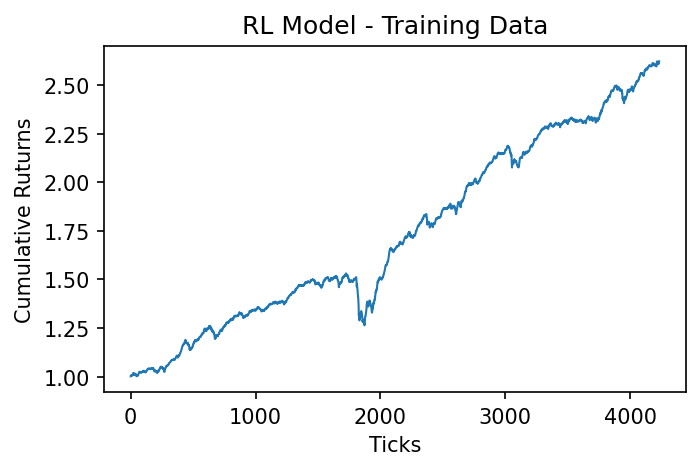

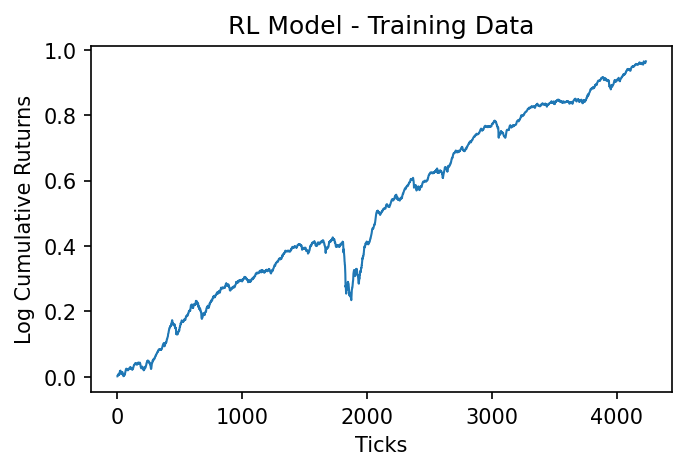

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 150

weights = gradient_ascent_results[-1, 3:]
train_data_array = np.array(train_data.pct_change().iloc[1:, :]).T
train_data_array = np.average(train_data_array, axis=0, weights=weights)

plt.plot((1+(train_data_array)).cumprod(), linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Ruturns')
plt.title("RL Model - Training Data")
plt.show()
plt.plot(np.log((1+(train_data_array)).cumprod()), linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Ruturns')
plt.title("RL Model - Training Data")
plt.show()

## Testing the model

Test data from 2018 to 2023

In [40]:
test_data_2018 = test_data[(test_data.index >= '2018-01-01') & (test_data.index <= '2018-12-31')]
test_data_2019 = test_data[(test_data.index >= '2019-01-01') & (test_data.index <= '2019-12-31')]
test_data_2020 = test_data[(test_data.index >= '2020-01-01') & (test_data.index <= '2020-12-31')]
test_data_2021 = test_data[(test_data.index >= '2021-01-01') & (test_data.index <= '2021-12-31')]
test_data_2022 = test_data[(test_data.index >= '2022-01-01') & (test_data.index <= '2022-12-31')]
test_data_2023 = test_data[(test_data.index >= '2023-01-01') & (test_data.index <= '2023-06-01')]
test_data_frames = {}
test_results_year = []
test_returns_year = []
for year in range(2018, 2024):
    test_data_frames[year] = locals()[f'test_data_{year}']
    test_data_returns = test_data_frames[year].pct_change().iloc[1:, :]
    test_mean_ret = test_data_returns.mean()
    cov = test_data_returns.cov()
    n_stocks = len(data.columns)
    test_weights = gradient_ascent_results[-1, 3:]
    if year != 2023:
        ret = np.sum(test_mean_ret * test_weights) * 252
        std = np.sqrt(np.dot(test_weights.T, np.dot(cov, test_weights))) * np.sqrt(252)
    else:
        ret = np.sum(test_mean_ret * test_weights) * 108
        std = np.sqrt(np.dot(test_weights.T, np.dot(cov, test_weights))) * np.sqrt(108)
    sharpe_ratio = ret / std
    test_results_year.append([ret, std, sharpe_ratio])
    test_returns_year.append(ret)

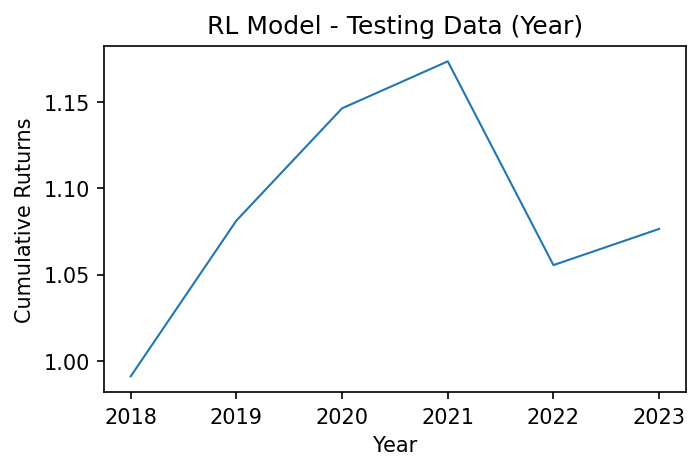

In [42]:
test_returns_year = np.array(test_returns_year)
x_values = np.array([2018, 2019, 2020, 2021, 2022, 2023])
plt.plot(x_values, (1+(test_returns_year)).cumprod(), linewidth=1)
plt.xticks(x_values)
plt.xlabel('Year')
plt.ylabel('Cumulative Ruturns')
plt.title("RL Model - Testing Data (Year)")
plt.show()

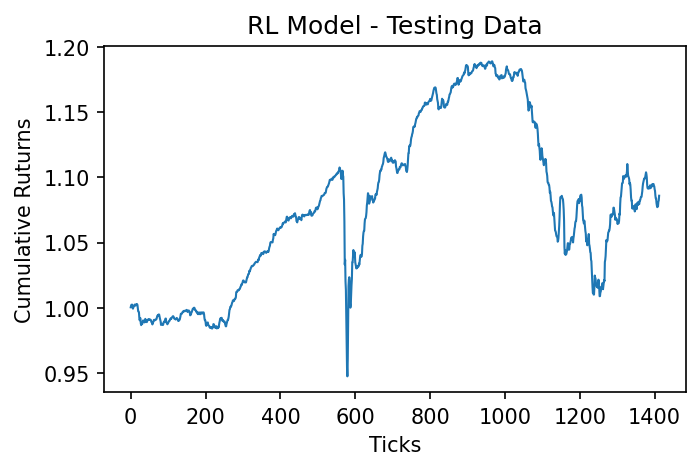

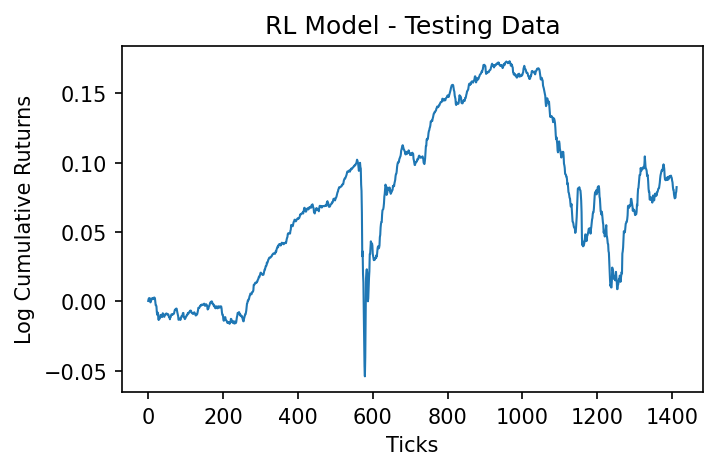

In [44]:
test_data_array = np.array(test_data.pct_change().iloc[1:, :]).T
test_data_array = np.average(test_data_array, axis=0, weights=weights)

plt.plot((1+(test_data_array)).cumprod(), linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Ruturns')
plt.title("RL Model - Testing Data")
plt.show()
plt.plot(np.log((1+(test_data_array)).cumprod()), linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Ruturns')
plt.title("RL Model - Testing Data")
plt.show()

In [45]:
# performance metrics
performance_df = pd.DataFrame(index=['value'])
test_data_array = np.array(test_data.pct_change().iloc[1:, :]).T
test_data_array = np.average(test_data_array, axis=0, weights=weights)
for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio']:
    fuc = eval('empyrical.' + metric)
    performance_df[metric] = [fuc(test_data_array)]
performance_df['omega_ratio'] = empyrical.omega_ratio(test_data_array, required_return = 0.05)
performance_df['sortino_ratio'] = empyrical.sortino_ratio(test_data_array, required_return = 0.05 / 252)
weights_df = pd.DataFrame(weights)
turnover_df = (weights_df - weights_df.shift(1)).dropna(how = 'all').abs().sum(axis = 1) / 2
annual_turnover = turnover_df.mean() * 252
performance_df['annual_turnover'] = annual_turnover
performance_df['annual_return'] = (1 + test_data_array).cumprod()[-1]
performance_df['annual_return'] = (1 + performance_df['annual_return']) ** (252 / len(test_data_array)) - 1
temp = 0
for i in range(6):
    temp += test_results_year[i][2]
performance_df['sharpe_ratio'] = temp / 6

In [46]:
performance_df

,annual_return,sharpe_ratio,max_drawdown,calmar_ratio,omega_ratio,sortino_ratio,annual_turnover
value,0.140097,1.282009,-0.151348,0.097761,0.816522,-1.071675,5.665987


# Reinforcement_Learning_with_Gradient_Ascent_for_Trading

## Trader Function to determine the portfolio's position

$F_t$ is the position at time t. The output of the trader function is the percentage between -1 and 1, which determines how many percentages of the assets' position in the portfolio should be opened or closed. $\theta$ are the parameters that are optimized by using gradient ascent. $x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $ is the input vector, where $r_t$ is the asset's prices difference at time $t$ and $t - 1$, and $M$ is the number of $r_t$ in $x_t$ for calculating each $F_t$. Therefore, at each time step, the model utilizes its previous position along with a series of historical price changes to determine its next position.

$$F _t = \tanh(\theta^T x _t)$$

In [47]:
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T, dtype=np.float64)#
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

## Returns Formula

After knowing what position will be at each time step, the portfolio's return can be calculated by the following formula from the paper, 
[Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf).

$$R_t = F_{t-1}r_t - \delta | F_t - F_{t - 1}| $$, where $\delta$ is the cost for a transaction at period $t$.

The returns function can be used for calculating the Sharpe ratio and the portfolio's return.

In [48]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

## Gradient Ascent

$$\theta_{new} = \theta_{old} + \alpha {{dS}\over{d \theta}}$$, where S is the sharpe ratio function, and $\alpha$ is the learning rate.

$${{dS _T}\over{d\theta}} = \sum\limits_{t=1}^{T} ( {{dS _T}\over{dA}}{{dA}\over{dR _t}} + {{dS _T}\over{dB}}{{dB}\over{dR _t}}) \cdot ({{dR _t}\over{dF _t}}{{dF}\over{d\theta}} + {{dR _t}\over{dF _{t-1}}}{{dF _{t-1}}\over{d\theta}})$$

Refer to Gabriel Molina's paper, [Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf), to see the complete steps for calculating the derivative and the partial derivatives mentioned above.

In [49]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

## Training Function

Train the model to optimize the parameters $\theta$ by using gradient ascent.

In [50]:
def train(x, epochs=1200, M=8, commission=0.0025, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    print("finished training")
    return theta, sharpes

## Data Loading

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 150

rets = pd.read_parquet('./price.pq').pct_change().iloc[1:, :]
rets = rets.dropna()

## Data preprocessing

Split data into training and test data and then normalize with the training data.

In [52]:
x = np.array(rets, dtype=np.float64)#

# Define start and end of the test period
test_start = pd.to_datetime('2018-01-01')
test_end = pd.to_datetime('2023-06-01')

# Split into training and testing datasets
x_tr = rets[rets.index < test_start]
x_te = rets[(rets.index >= test_start) & (rets.index <= test_end)]

x_train = np.array(x_tr).T
x_test = np.array(x_te).T

std = np.std(x_train, axis=1, keepdims=True)
mean = np.mean(x_train, axis=1, keepdims=True)

weights = np.load('weights.npy')
x_train = (x_train - mean) / std
x_train = np.average(x_train, axis=0, weights=weights)
x_test = (x_test - mean) / std
x_test = np.average(x_test, axis=0, weights=weights)

## Training the model

In [53]:
t0 = time.time()
theta, sharpes = train(x_train, epochs=1200, M=8, commission=0.0025, learning_rate=0.3)
t1 = time.time()
print("cpu time {}".format(t1 - t0))

finished training
cpu time 42.39754104614258


To evaluate the effectiveness of the training, the resulting Sharpe ratio can be plotted over each epoch to observe how it converges to a maximum.

Text(0, 0.5, 'Sharpe Ratio')

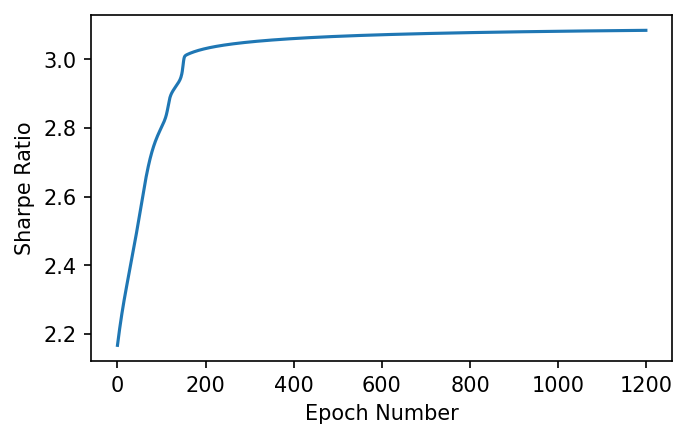

In [54]:
plt.plot(sharpes * np.sqrt(252))
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio')

After $\theta$ are updated, $\theta$ can be used to calculate the portfolio's return. The reinforcement learning model greatly outperformed the benchmark method.

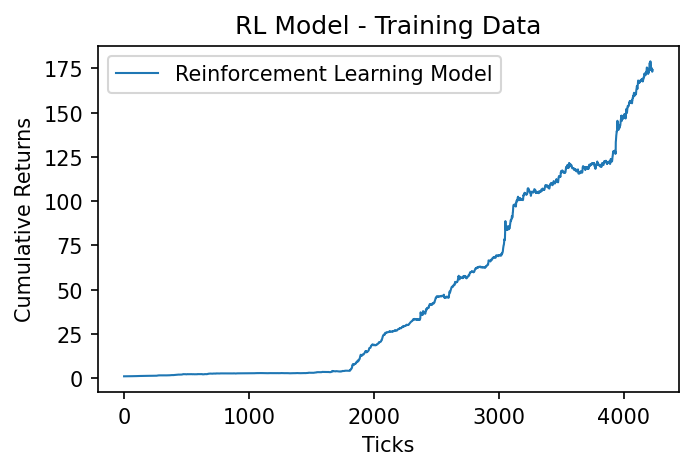

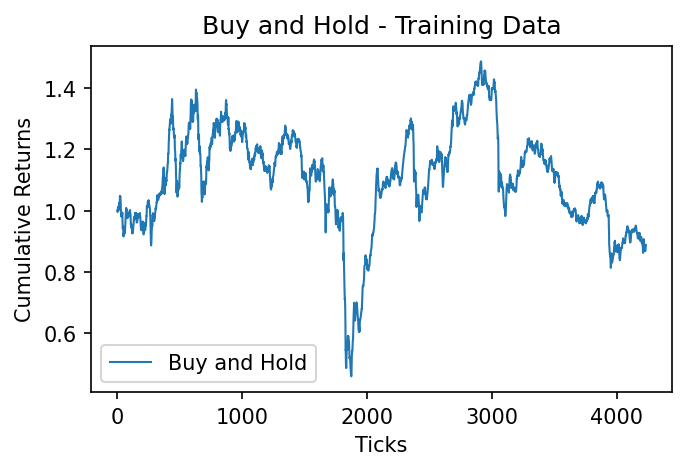

In [55]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((1 + train_returns/100).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model - Training Data")
plt.show()
plt.plot((1 + x_train/100).cumprod(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("Buy and Hold - Training Data")
plt.show()

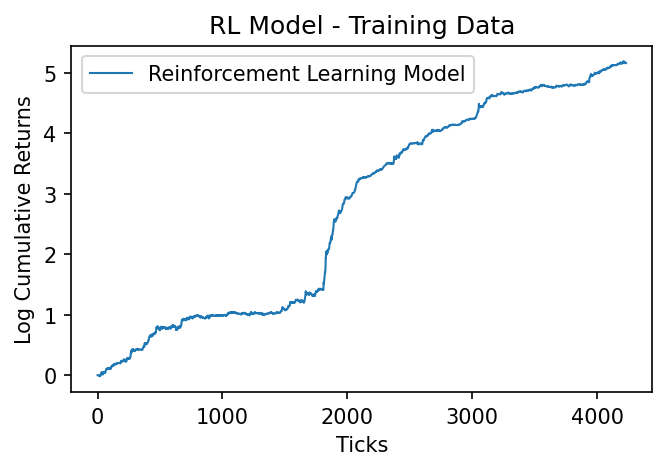

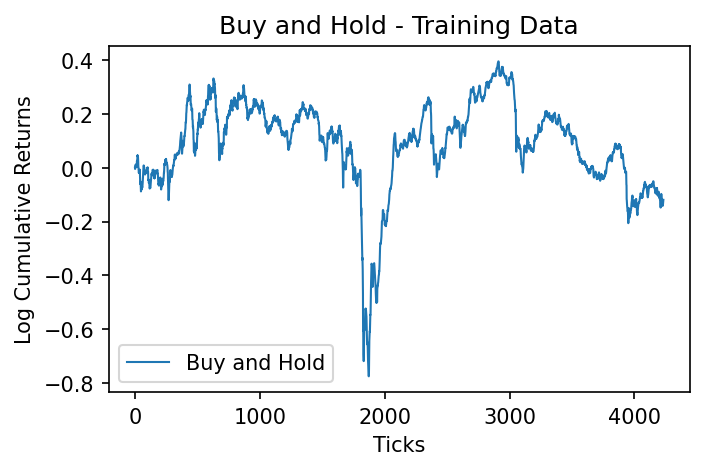

In [56]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot(np.log((1 + train_returns/100).cumprod()), label="Reinforcement Learning Model", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Returns')
plt.legend()
plt.title("RL Model - Training Data")
plt.show()
plt.plot(np.log((1 + x_train/100).cumprod()), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Returns')
plt.legend()
plt.title("Buy and Hold - Training Data")
plt.show()

## Testing the model

The test data is used for the final performance evaluation.

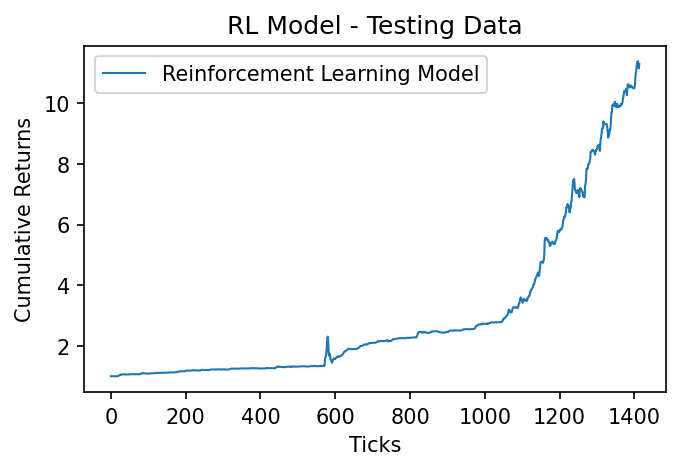

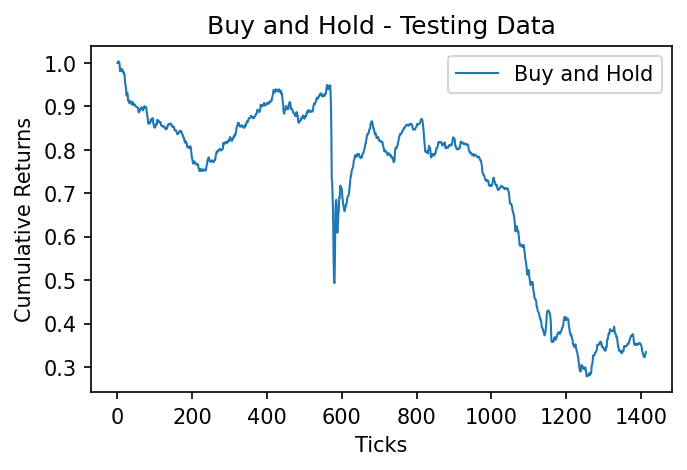

In [57]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((1 + test_returns/100).cumprod(), label="Reinforcement Learning Model", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model - Testing Data")
plt.show()
plt.plot((1 + x_test/100).cumprod(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("Buy and Hold - Testing Data")
plt.show()

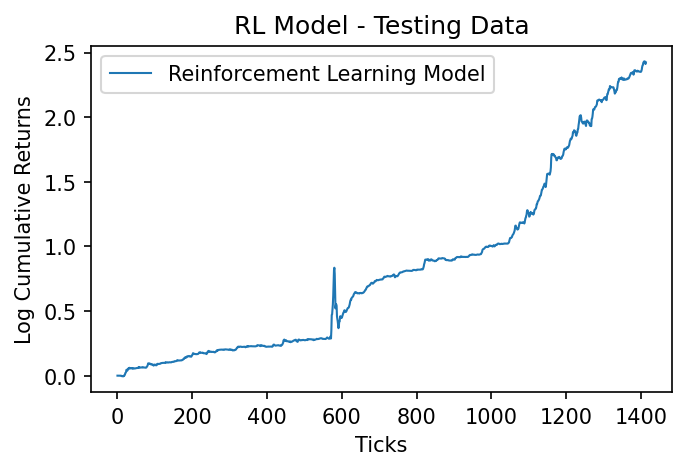

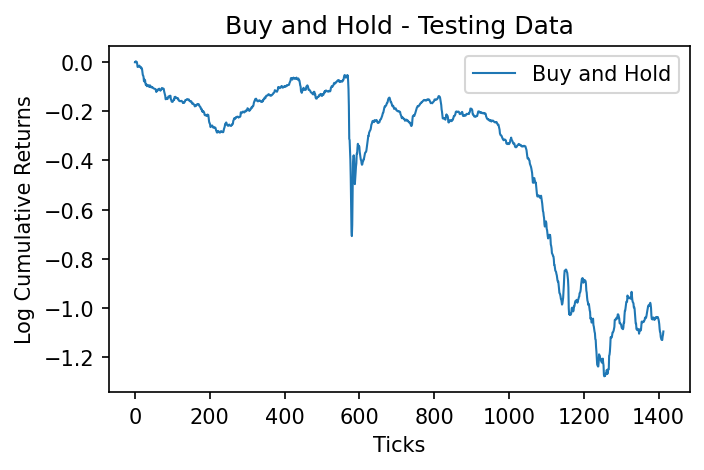

In [58]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot(np.log((1 + test_returns/100).cumprod()), label="Reinforcement Learning Model", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Returns')
plt.legend()
plt.title("RL Model - Testing Data")
plt.show()
plt.plot(np.log((1 + x_test/100).cumprod()), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Log Cumulative Returns')
plt.legend()
plt.title("Buy and Hold - Testing Data")
plt.show()

In [59]:
# performance metrics
performance_df = pd.DataFrame(index=['value'])
for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio', 'omega_ratio', 'sortino_ratio']:
    fuc = eval('empyrical.' + metric)
    performance_df[metric] = [fuc(test_returns/100)]
performance_df['omega_ratio'] = empyrical.omega_ratio(test_returns/100, required_return = 0.05)
performance_df['sortino_ratio'] = empyrical.sortino_ratio(test_returns/100, required_return = 0.05 / 252)

In [60]:
performance_df

,annual_return,sharpe_ratio,max_drawdown,calmar_ratio,omega_ratio,sortino_ratio
value,0.540362,2.730979,-0.373443,1.446973,2.219072,4.126195


In [61]:
# performance metrics
performance_df = pd.DataFrame(index=['value'])
for metric in ['annual_return', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio', 'omega_ratio', 'sortino_ratio']:
    fuc = eval('empyrical.' + metric)
    performance_df[metric] = [fuc(x_test/100)]
performance_df['omega_ratio'] = empyrical.omega_ratio(x_test/100, required_return = 0.05)
performance_df['sortino_ratio'] = empyrical.sortino_ratio(x_test/100, required_return = 0.05 / 252)

In [62]:
performance_df

,annual_return,sharpe_ratio,max_drawdown,calmar_ratio,omega_ratio,sortino_ratio
value,-0.177366,-1.020627,-0.722205,-0.245589,0.700793,-1.683025
